In [ ]:
# default_exp data.core

# Data Core

> Main Numpy and Times Series functions used throughout the library.

In [ ]:
#export
from types import MethodType
from matplotlib.ticker import PercentFormatter
import matplotlib.colors as mcolors
from matplotlib import rcParams
from fastcore.transform import Transform, DisplayedTransform, Pipeline
from fastai.data.transforms import (RandomSplitter, ItemGetter, MultiCategorize, CategoryMap,
Category, MultiCategory, Categorize)
from fastai.data.core import TfmdLists, Datasets, TfmdDL, DataLoaders
from fastai.data.load import DataLoader
from fastai.data.block import CategoryBlock, DataBlock
from fastai.losses import MSELossFlat, CrossEntropyLossFlat, BCEWithLogitsLossFlat
from fastai.vision.data import get_grid
from tsai.imports import *
from tsai.utils import *

In [ ]:
from tsai.data.external import get_UCR_data
dsid = 'OliveOil'
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, on_disk=True, force_download=True)
X_on_disk, y_on_disk, splits = get_UCR_data(dsid, on_disk=True, return_split=False, force_download=True)
X_in_memory, y_in_memory, splits = get_UCR_data(dsid, on_disk=False, return_split=False, force_download=True)
y_tensor = cat2int(y_on_disk)
y_array = y_tensor.numpy()

In [ ]:
#export
class NumpyTensor(TensorBase):
    "Returns a `tensor` with subclass `NumpyTensor` that has a show method"

    def __new__(cls, o, **kwargs):
        res = cast(o, cls)
        for k,v in kwargs.items(): setattr(res, k, v)
        return res
        
    @property
    def data(self): return cast(self, Tensor).data
    
    def __repr__(self):
        if self.ndim > 0: return f'NumpyTensor(shape:{tuple(self.shape)}, device={self.device})'
        else: return f'NumpyTensor([{self}], device={self.device})'
        

    def show(self, ax=None, ctx=None, title=None, **kwargs):
        if self.ndim == 0: return str(self)
        elif self.ndim != 2: self = type(self)(to2d(self))
        if not isinstance(self,np.ndarray): self = self.detach().cpu().numpy()
        ax = ifnone(ax, ctx)
        if ax is None: _, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        title_color = kwargs['title_color'] if 'title_color' in kwargs else rcParams['axes.labelcolor']
        if title is not None:
            if is_listy(title): title = str(title)[1:-1]
            ax.set_title(title, weight='bold', color=title_color)
        plt.tight_layout()
        return ax
    

class ToNumpyTensor(Transform):
    "Transforms an object into NumpyTensor"
    def encodes(self, o): return NumpyTensor(o)

In [ ]:
#export
class TSTensor(NumpyTensor):
    '''Returns a `tensor` with subclass `TSTensor` that has a show method'''
    
    @property
    def vars(self): 
        return self.shape[-2]

    @property
    def len(self): return self.shape[-1]

    def __repr__(self):
        if self.ndim >= 3:
            return f'TSTensor(samples:{self.shape[-3]}, vars:{self.shape[-2]}, len:{self.shape[-1]}, device={self.device})'
        elif self.ndim == 2:
            return f'TSTensor(vars:{self.shape[-2]}, len:{self.shape[-1]}, device={self.device})'
        elif self.ndim == 1:
            return f'TSTensor(len:{self.shape[-1]}, device={self.device})'
        else: return f'TSTensor([{self}], device={self.device})'


class ToTSTensor(Transform):
    "Transforms an object into TSTensor"
    def encodes(self, o): return TSTensor(o)
    
    
@delegates(plt.subplots)
def show_tuple(tup, **kwargs):
    "Display a timeseries plot from a decoded tuple"
    if len(tup) == 1: title = 'unlabeled'
    elif is_listy(tup[1]): title = str(tup[1])[1:-1]
    else: title = str(tup[1])
    tup[0].show(title=title, **kwargs)

In [ ]:
a = np.random.randn(2, 3, 4)
test_eq(TSTensor(a.tolist()).shape, a.shape)

In [ ]:
t = TSTensor(torch.randn(2, 3, 4))
p = torch.tensor(3., requires_grad=True)
test = torch.add(t, p)
test_eq(test.requires_grad, True)
test_eq(type(t.data), torch.Tensor)
test_eq(type(t), TSTensor)

In [ ]:
l = L([0,1,2,3], [4,5,6,7], [8, 9, 10, 11])
TSTensor(l), TSTensor(l).data

(TSTensor(vars:3, len:4, device=cpu),
 tensor([[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]]))

In [ ]:
t = TSTensor(X_train)
for i in range(4):
    print(t, t.ndim, torch.is_tensor(t))
    if i < 3: t = t[0]

TSTensor(samples:30, vars:1, len:570, device=cpu) 3 True
TSTensor(vars:1, len:570, device=cpu) 2 True
TSTensor(len:570, device=cpu) 1 True
TSTensor([-0.6113752722740173], device=cpu) 0 True


In [ ]:
TSTensor(X_on_disk)

TSTensor(samples:60, vars:1, len:570, device=cpu)

In [ ]:
ToTSTensor()(X_on_disk)

TSTensor(samples:60, vars:1, len:570, device=cpu)

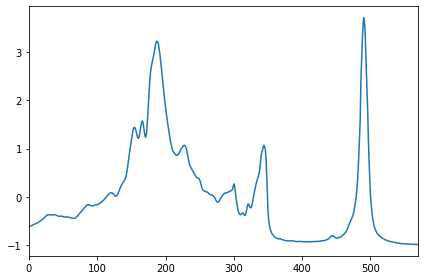

In [ ]:
TSTensor(X_train).show();

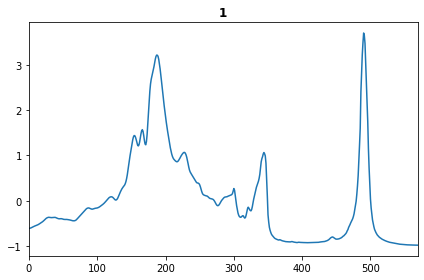

In [ ]:
TSTensor(X_train).show(title='1');

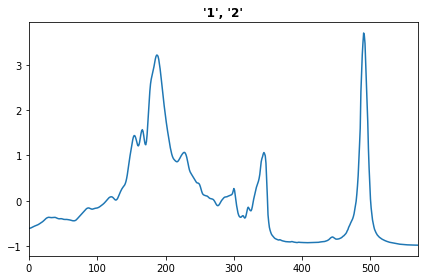

In [ ]:
show_tuple((TSTensor(X_train), ['1', '2']))

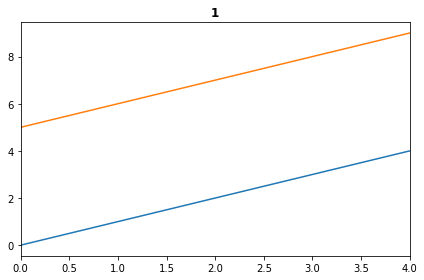

In [ ]:
show_tuple((TSTensor(np.arange(10).reshape(2,5)), 1))

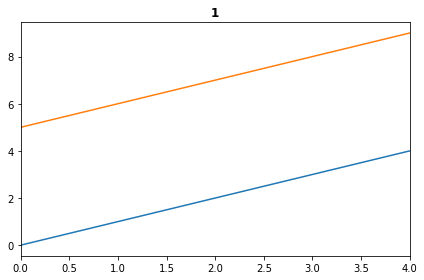

In [ ]:
show_tuple((TSTensor(np.arange(10).reshape(2,5)), '1'))

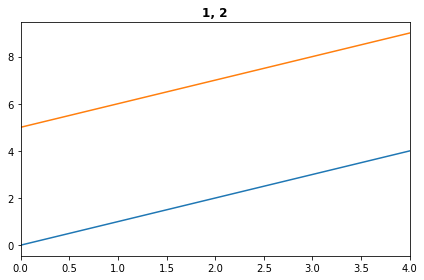

In [ ]:
show_tuple((TSTensor(np.arange(10).reshape(2,5)), [1,2]))

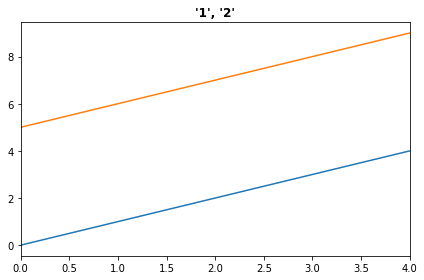

In [ ]:
show_tuple((TSTensor(np.arange(10).reshape(2,5)), ['1', '2']))

In [ ]:
#export
class TSLabelTensor(NumpyTensor): 
    def __repr__(self):
        if self.ndim == 0: return f'{self}'
        else: return f'TSLabelTensor(shape:{tuple(self.shape)})'

class TSMaskTensor(NumpyTensor): 
    def __repr__(self):
        if self.ndim == 0: return f'{self}'
        else: return f'TSMaskTensor(shape:{tuple(self.shape)})'

In [ ]:
t = TSLabelTensor(torch.randint(0,10,(1, 2, 3)))
t, t[0], t[0][0], t[0][0][0]

(TSLabelTensor(shape:(1, 2, 3)),
 TSLabelTensor(shape:(2, 3)),
 TSLabelTensor(shape:(3,)),
 6)

In [ ]:
t = TSMaskTensor(torch.randint(0,10,(1, 2, 3)))
t, t[0], t[0][0], t[0][0][0]

(TSMaskTensor(shape:(1, 2, 3)),
 TSMaskTensor(shape:(2, 3)),
 TSMaskTensor(shape:(3,)),
 6)

In [ ]:
#export
class ToFloat(Transform):
    "Transforms an object dtype to float (vectorized)"
    vectorized=True
    loss_func=MSELossFlat()
    def encodes(self, o:torch.Tensor): return o.float()
    def encodes(self, o): return o.astype(np.float32)
    def decodes(self, o): 
        if o.ndim==0: return TitledFloat(o) 
        else: 
            return TitledTuple(o.cpu().numpy().tolist())
            

class ToInt(Transform):
    "Transforms an object dtype to int"
    def encodes(self, o:torch.Tensor): return o.long()
    def encodes(self, o): return o.astype(np.float32).astype(np.int64)
    def decodes(self, o): 
        if o.ndim==0: return TitledFloat(o) 
        else: 
            return TitledTuple(o.cpu().numpy().tolist())
    
    
class TSClassification(DisplayedTransform):
    "Vectorized, reversible transform of category string to `vocab` id"
    loss_func,order,vectorized=CrossEntropyLossFlat(),1,True

    def __init__(self, vocab=None, sort=True):
        if vocab is not None: vocab = CategoryMap(vocab, sort=sort, add_na=False)
        store_attr()

    def setups(self, dset):
        if self.vocab is None and dset is not None:
            dset = np.asarray(dset).flatten()
            self.vocab = CategoryMap(dset, sort=self.sort, add_na=False)
        self.c = len(self.vocab)
        self.vocab_keys = np.array(list(self.vocab.o2i.keys()))[:, None]

    def encodes(self, o):
        try:
            if not hasattr(o, "ndim") or o.ndim <= 1:
                return TensorCategory((self.vocab_keys == o).argmax(axis=0))
            else:
                return TensorCategory((self.vocab_keys == o.flatten()).argmax(axis=0).reshape(*o.shape))
        except KeyError as e:
            raise KeyError(f"Label '{o}' was not included in the training dataset") from e
    def decodes(self, o):
        if not is_iter(o):
            return Category(self.vocab[o])
        elif o.ndim <= 1:
            return stack([Category(self.vocab[oi]) for oi in o])
        else:
            return stack(MultiCategory(self.vocab[o.flatten()])).reshape(*o.shape)

        
TSCategorize = TSClassification
TSRegression = ToFloat
TSForecasting = ToFloat

In [ ]:
a = np.random.randint(0, 2, 10)
b = np.array(['1', '2', '3'])
c = np.array(['1.0', '2.0', '3.0'])
t = torch.randint(0, 2, (10, ))
test_eq(ToFloat()(a).dtype, 'float32')
test_eq(ToFloat()(b).dtype, 'float32')
test_eq(ToFloat()(c).dtype, 'float32')
test_eq(ToFloat()(t).dtype, torch.float32)

In [ ]:
a = np.random.rand(10)*10
b = np.array(['1.0', '2.0', '3.0'])
t = torch.rand(10)*10
test_eq(ToInt()(a).dtype, 'int64')
test_eq(ToInt()(b).dtype, 'int64')
test_eq(ToInt()(t).dtype, torch.long)

In [ ]:
t = TSClassification()
t.setup(y_on_disk[splits[0]])
y_encoded = t(y_on_disk)
print(y_encoded)
test_eq(t.decodes(y_encoded), y_on_disk)

TensorCategory([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


In [ ]:
y_multi= np.random.randint(0,3,20)
y_multi = np.asarray(alphabet[y_multi]).reshape(4,5)
tfm = TSClassification()
tfm.setup(y_multi)
enc_y_multi = tfm(y_multi)
test_eq(y_multi, tfm.decode(enc_y_multi))
enc_y_multi

TensorCategory([[1, 0, 2, 1, 0],
        [2, 0, 0, 1, 1],
        [1, 2, 1, 2, 0],
        [1, 2, 1, 0, 2]])

In [ ]:
#export
class TSMultiLabelClassification(Categorize):
    "Reversible combined transform of multi-category strings to one-hot encoded `vocab` id"
    loss_func,order=BCEWithLogitsLossFlat(),1
    def __init__(self, c=None, vocab=None, add_na=False, sort=True): 
        super().__init__(vocab=vocab,add_na=add_na,sort=sort)
        self.c = c

    def setups(self, dsets):
        if not dsets: return
        if self.vocab is None:
            vals = set()
            for b in dsets: vals = vals.union(set(b))
            self.vocab = CategoryMap(list(vals), add_na=self.add_na)
            if self.c is None: self.c = len(self.vocab)
            if not self.c: warn("Couldn't infer the number of classes, please pass a value for `c` at init")

    def encodes(self, o):
        if not all(elem in self.vocab.o2i.keys() for elem in o):
            diff = [elem for elem in o if elem not in self.vocab.o2i.keys()]
            diff_str = "', '".join(diff)
            raise KeyError(f"Labels '{diff_str}' were not included in the training dataset")
        return TensorMultiCategory(one_hot([self.vocab.o2i[o_] for o_ in o], self.c).float())
    def decodes(self, o): return MultiCategory([self.vocab[o_] for o_ in one_hot_decode(o, None)])

In [ ]:
#export

class NumpyTensorBlock():
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =                 L(type_tfms)
        self.item_tfms  = ToNumpyTensor + L(item_tfms)
        self.batch_tfms =                 L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)
        
class TSTensorBlock():
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =              L(type_tfms)
        self.item_tfms  = ToTSTensor + L(item_tfms)
        self.batch_tfms =              L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)

In [ ]:
test_eq(NumpyTensorBlock().item_tfms[0].__name__, 'ToNumpyTensor')
test_eq(TSTensorBlock().item_tfms[0].__name__, 'ToTSTensor')

In [ ]:
#export
class TorchDataset():
    def __init__(self, X, y=None): self.X, self.y = X, y
    def __getitem__(self, idx): return (self.X[idx],) if self.y is None else (self.X[idx], self.y[idx])
    def __len__(self): return len(self.X)

    
class NumpyDataset():
    def __init__(self, X, y=None, types=None): self.X, self.y, self.types = X, y, types
    def __getitem__(self, idx):
        if self.types is None: return (self.X[idx], self.y[idx]) if self.y is not None else (self.X[idx])
        else: return (self.types[0](self.X[idx]), self.types[1](self.y[idx])) if self.y is not None else (self.types[0](self.X[idx]))
    def __len__(self): return len(self.X)


class TSDataset():
    def __init__(self, X, y=None, types=None, sel_vars=None, sel_steps=None):
        self.X, self.y, self.types = to3darray(X), y, types
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
    def __getitem__(self, idx):
        if self.types is None: return (self.X[idx, self.sel_vars, self.sel_steps], self.y[idx]) if self.y is not None else (self.X[idx])
        else:
            return (self.types[0](self.X[idx, self.sel_vars, self.sel_steps]), self.types[1](self.y[idx])) if self.y is not None \
            else (self.types[0](self.X[idx]))
    def __len__(self): return len(self.X)

In [ ]:
a = np.random.rand(5,6,7)
b = np.random.rand(5)
ds = NumpyDataset(a,b)
xb, yb = ds[[0,4]]
test_eq(xb.shape, (2,6,7))
test_eq(yb.shape, (2,))

In [ ]:
#export
def _flatten_list(l):
    if not is_listy(l) or len(l) == 0: return l
    return [item for sublist in l for item in listify(sublist)]

def _remove_brackets(l):
    return [li if (not li or not is_listy(li) or len(li) > 1) else li[0] for li in l]
    
class NoTfmLists(TfmdLists):
    def __init__(self, items, tfms=None, splits=None, split_idx=None, types=None, do_setup=False, **kwargs):
        self.splits = ifnone(splits, L(np.arange(len(items)).tolist(),[]))
        self._splits = np.asarray(_flatten_list(self.splits))
        store_attr('items,types,split_idx')
        self.tfms = Pipeline(split_idx=split_idx)
    def subset(self, i, **kwargs): return type(self)(self.items, splits=self.splits[i], split_idx=i, do_setup=False, types=self.types, **kwargs)
    def __getitem__(self, it):
        if hasattr(self.items, 'oindex'): return self.items.oindex[self._splits[it]]
        else: return self.items[self._splits[it]]
    def __len__(self): return len(self._splits)
    def __repr__(self): return f"{self.__class__.__name__}: {self.items.__class__.__name__}{(len(self), *self.items.shape[1:])}"
    def _new(self, items, split_idx=None, **kwargs):
        split_idx = ifnone(split_idx, self.split_idx)
        return type(self)(items, split_idx=split_idx, do_setup=False, types=self.types, **kwargs)
    def decode(self, o, **kwargs): return o
    def new_empty(self): return self._new([])

NoTfmLists.train, NoTfmLists.valid = add_props(lambda i,x: x.subset(i))

class TSTfmdLists(TfmdLists):
    def __getitem__(self, it):
        # res = self._get(it)
        if hasattr(self.items, 'oindex'): res = self.items.oindex[it] 
        else: res = self.items[it]
        if self._after_item is None: return res
        else: return self._after_item(res)

In [ ]:
items = X_on_disk
tl = TfmdLists(items, tfms=None, splits=splits)
test_eq(len(tl), len(X_on_disk))
test_eq(len(tl.train), len(splits[0]))
test_eq(len(tl.valid), len(splits[1]))
test_eq(tl[[0,4,7]], X_on_disk[[0,4,7]])
test_eq(tl.train[[0,4,7]], X_on_disk[splits[0][0,4,7]])
test_eq(tl.valid[[0,4,7]], X_on_disk[splits[1][0,4,7]])
test_eq(tl[0], items[0])
test_eq(tl[[0,1]], items[[0,1]])
test_eq(tl.decode(tl[0]), tl[0])
test_eq((tl.split_idx, tl.train.split_idx, tl.valid.split_idx), (None, 0, 1))

In [ ]:
items = X_on_disk
tl = TSTfmdLists(items, tfms=None, splits=splits)
test_eq(len(tl), len(X_on_disk))
test_eq(len(tl.train), len(splits[0]))
test_eq(len(tl.valid), len(splits[1]))
test_eq(tl[[0,4,7]], X_on_disk[[0,4,7]])
test_eq(tl.train[[0,4,7]], X_on_disk[splits[0][0,4,7]])
test_eq(tl.valid[[0,4,7]], X_on_disk[splits[1][0,4,7]])
test_eq(tl[0], items[0])
test_eq(tl[[0,1]], items[[0,1]])
test_eq(tl.decode(tl[0]), tl[0])
test_eq((tl.split_idx, tl.train.split_idx, tl.valid.split_idx), (None, 0, 1))

In [ ]:
items = X_on_disk
ntl = NoTfmLists(items, splits=splits)
test_eq(len(ntl), len(X_on_disk))
test_eq(len(ntl.train), len(splits[0]))
test_eq(len(ntl.valid), len(splits[1]))
test_eq(ntl._splits, np.arange(len(X_on_disk)))
test_eq(ntl.train._splits, np.arange(len(splits[0])))
test_eq(ntl.valid._splits, np.arange(len(splits[0]), len(X_on_disk)))
print(ntl)
print(ntl.train)
print(ntl.valid)
test_eq(ntl[[0,4,7]], X_on_disk[[0,4,7]])
test_eq(ntl.train[[0,4,7]], X_on_disk[splits[0][0,4,7]])
test_eq(ntl.valid[[0,4,7]], X_on_disk[splits[1][0,4,7]])
test_eq(ntl[0], items[0])
test_eq(ntl[[0,1]], items[[0,1]])
test_eq(ntl[:], X_on_disk)
ntl[0].shape, stack(ntl[[0,1]]).shape
test_eq(ntl.decode(ntl[0]), ntl[0])
assert id(items) == id(ntl.items) == id(ntl.train.items) == id(ntl.valid.items)
test_eq((ntl.split_idx, ntl.train.split_idx, ntl.valid.split_idx), (None, 0, 1))

NoTfmLists: memmap(60, 1, 570)
NoTfmLists: memmap(30, 1, 570)
NoTfmLists: memmap(30, 1, 570)


In [ ]:
subitems = X_on_disk
new_ntl = ntl._new(X_on_disk)
test_eq(new_ntl[:], X_on_disk)

In [ ]:
idxs = np.random.choice(len(X_on_disk), 10, False)
new_ntl = ntl._new(X_on_disk[idxs])
test_eq(new_ntl[:], X_on_disk[idxs])

In [ ]:
idxs = np.random.choice(len(X_on_disk), 10, False)
new_ntl = ntl.valid._new(X_on_disk[idxs])
test_eq(new_ntl[:], X_on_disk[idxs])

In [ ]:
#export
@delegates(Datasets.__init__)
class NumpyDatasets(Datasets):
    "A dataset that creates tuples from X (and y) and applies `tfms` of type item_tfms"
    typs = NumpyTensor,tensor
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, inplace=True, **kwargs):

        self.tfms, self.inplace = tfms, inplace

        if X is not None:
            if not hasattr(X, '__array__'): X = np.asarray(X)
            elif hasattr(X, "iloc"): X = to3d(X)
        if y is not None:
            if not hasattr(y, '__array__'):  y = np.asarray(y)
            elif hasattr(y, "iloc"): y = toarray(y)

        if tls is None:
            items = tuple((X,)) if y is None else tuple((X, y))

            if tfms is None:
                self.tfms, lts = [None] * len(items), [NoTfmLists] * len(items)
            else:
                self.tfms = _remove_brackets(tfms)
                ts = [NoTfmLists if t is None else TSTfmdLists if getattr(t, 'vectorized', None) else TfmdLists for t in self.tfms]

            self.tls = L(lt(item, t, **kwargs) for lt,item,t in zip(lts, items, self.tfms))
            if len(self.tls) > 0 and len(self.tls[0]) > 0:
                self.typs = [type(tl[0]) if isinstance(tl[0], torch.Tensor) else self.typs[i] for i,tl in enumerate(self.tls)]
            self.ptls = L([typ(stack(tl[:])) for i,(tl,typ) in enumerate(zip(self.tls,self.typs))]) if inplace else self.tls
        else:
            self.tls = tls
            if len(self.tls) > 0 and len(self.tls[0]) > 0:
                self.typs = [type(tl[0]) if isinstance(tl[0], torch.Tensor) else self.typs[i] for i,tl in enumerate(self.tls)]
            self.ptls = L([typ(stack(tl[:])) for i,(tl,typ) in enumerate(zip(self.tls,self.typs))]) if inplace and len(tls[0]) != 0 else tls

        self.n_inp = 1
        if 'splits' in kwargs:
            split_idxs = kwargs['splits']
            try: split_idxs = flatten_list(split_idxs)
            except: pass
        else: split_idxs = L(np.arange(len(self.tls[0])).tolist())
        self.split_idxs = L(split_idxs)

    def __getitem__(self, it):
        if self.inplace:
            return tuple([ptl[it] for ptl in self.ptls])
        else:
            return tuple([typ(stack(ptl[it])) for i,(ptl,typ) in enumerate(zip(self.ptls,self.typs))])

    def subset(self, i):
        if is_indexer(i):
            return type(self)(tls=L([tl.subset(i) for tl in self.tls]), inplace=self.inplace, tfms=self.tfms,
                              splits=None if self.splits is None else self.splits[i], split_idx=i)
        else:
            splits = None if self.splits is None else L(np.arange(len(i)).tolist())
            return type(self)(*self[i], inplace=True, tfms=None, splits=splits, split_idx=ifnone(self.split_idx, 1))

    def __len__(self): return len(self.tls[0])
    
    def _new(self, X, y=None, **kwargs):
        return type(self)(X, y=y, tfms=self.tfms, inplace=self.inplace, do_setup=False, **kwargs)

    def new_empty(self): return type(self)(tls=[tl.new_empty() for tl in self.tls], n_inp=self.n_inp, inplace=self.inplace)
    
    def show_at(self, idx, **kwargs):
        self.show(self[idx], **kwargs)
        plt.show()
        
    def __repr__(self): return tscoll_repr(self)


def tscoll_repr(c, max_n=10):
    "String repr of up to `max_n` items of (possibly lazy) collection `c`"
    _len = len(c)
    if _len == 0: return coll_repr(c)
    return f'(#{_len}) {L(c[i] for i in range(min(len(c), max_n)))} ...]'

In [ ]:
#export
@delegates(NumpyDatasets.__init__)
class TSDatasets(NumpyDatasets):
    """A dataset that creates tuples from X (and optionally y) and applies `item_tfms`"""
    typs = TSTensor,tensor
    def __init__(self, X=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None, inplace=True, **kwargs):

        self.multi_index = False
        if sel_vars is None or (type(sel_vars) == slice and sel_vars == slice(None)): self.sel_vars = slice(None)
        elif type(sel_vars) == slice: 
            self.sel_vars = sel_vars
            self.multi_index = True
        else:
            self.sel_vars = np.asarray(sel_vars)
            if sel_steps is not None and type(sel_steps) != slice: self.sel_vars = sel_vars[:, None]
            self.multi_index = True
        if sel_steps is None or (type(sel_steps) == slice and sel_steps == slice(None)): self.sel_steps = slice(None)
        elif type(sel_steps) == slice: 
            self.sel_steps = sel_steps
            self.multi_index = True
        else: 
            self.sel_steps = np.asarray(sel_steps)
            self.multi_index = True
        self.tfms, self.inplace = tfms, inplace

        if X is not None:
            if not hasattr(X, '__array__'): X = np.asarray(X)
            X = to3d(X)
        if y is not None:
            if not hasattr(y, '__array__'):  y = np.asarray(y)
            elif hasattr(y, "iloc"): y = toarray(y)

        if tls is None:
            items = tuple((X,)) if y is None else tuple((X, y))

            if tfms is None:
                self.tfms, lts = [None] * len(items), [NoTfmLists] * len(items)
            else:
                self.tfms = _remove_brackets(tfms)
                lts = [NoTfmLists if t is None else TSTfmdLists if getattr(t, 'vectorized', None) else TfmdLists for t in self.tfms]

            self.tls = L(lt(item, t, **kwargs) for lt,item,t in zip(lts, items, self.tfms))
            if len(self.tls) > 0 and len(self.tls[0]) > 0:
                self.typs = [type(tl[0]) if isinstance(tl[0], torch.Tensor) else self.typs[i] for i,tl in enumerate(self.tls)]
            self.ptls = L([typ(stack(tl[:]))[...,self.sel_vars, self.sel_steps] if (i==0 and self.multi_index) else typ(stack(tl[:])) \
                            for i,(tl,typ) in enumerate(zip(self.tls,self.typs))]) if inplace else self.tls
        else:
            self.tls = tls
            if len(self.tls) > 0 and len(self.tls[0]) > 0:
                self.typs = [type(tl[0]) if isinstance(tl[0], torch.Tensor) else self.typs[i] for i,tl in enumerate(self.tls)]
            self.ptls = L([typ(stack(tl[:]))[...,self.sel_vars, self.sel_steps] if (i==0 and self.multi_index) else typ(stack(tl[:])) \
                            for i,(tl,typ) in enumerate(zip(self.tls,self.typs))]) if inplace and len(tls[0]) != 0 else tls

        self.n_inp = 1
        if 'splits' in kwargs:
            split_idxs = kwargs['splits']
            try: split_idxs = flatten_list(split_idxs)
            except: pass
        else: split_idxs = L(np.arange(len(self.tls[0])).tolist())
        self.split_idxs = L(split_idxs)

    def __getitem__(self, it):
        if self.inplace:
            return tuple([ptl[it] for ptl in self.ptls])
        else:
            return tuple([typ(stack(ptl[it]))[...,self.sel_vars, self.sel_steps] if (i==0 and self.multi_index) else typ(stack(ptl[it])) \
                          for i,(ptl,typ) in enumerate(zip(self.ptls,self.typs))])

    def subset(self, i):
        if is_indexer(i):
            return type(self)(tls=L([tl.subset(i) for tl in self.tls]), inplace=self.inplace, tfms=self.tfms,
                              sel_vars=self.sel_vars, sel_steps=self.sel_steps, splits=None if self.splits is None else self.splits[i], split_idx=i)
        else:
            splits = None if self.splits is None else L(np.arange(len(i)).tolist())
            return type(self)(*self[i], inplace=True, tfms=None, 
                              sel_vars=self.sel_vars, sel_steps=self.sel_steps, splits=splits, split_idx=ifnone(self.split_idx, 1))
    
    def _new(self, X, y=None, **kwargs):
        return type(self)(X, y=y, sel_vars=self.sel_vars, sel_steps=self.sel_steps, tfms=self.tfms, inplace=self.inplace, 
                          do_setup=False, **kwargs)
    
    def new_empty(self): return type(self)(tls=[tl.new_empty() for tl in self.tls], sel_vars=self.sel_vars, sel_steps=self.sel_steps, 
                                           n_inp=self.n_inp, inplace=self.inplace)

In [ ]:
dsets = TSDatasets(X_on_disk, y_on_disk, splits=splits, tfms=[None, TSClassification()], inplace=True)
i = np.random.choice(len(splits[0]), 10, False).tolist()
test_eq(dsets.subset(i), dsets.train.subset(i))
dsets.valid.subset(i)
dsets.valid.subset(i)[[0,6,8]]
test_eq(dsets.subset(i)[[0,6,8]], dsets.train.subset(i)[[0,6,8]])
dsets.subset([0,7,3])
dsets.subset(i), dsets.train.subset(i), dsets.valid.subset(i)

((#10) [(TSTensor(vars:1, len:570, device=cpu), TensorCategory(2)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(3)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(3)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(2)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(1)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(1)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(1)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(0))] ...],
 (#10) [(TSTensor(vars:1, len:570, device=cpu), TensorCategory(2)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(3)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(3)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(2)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(1)), (TSTensor(vars:1, 

In [ ]:
#export
def add_ds(dsets, X, y=None, inplace=True):
    "Create test datasets from X (and y) using validation transforms of `dsets`"
    items = tuple((X,)) if y is None else tuple((X, y))
    with_labels = False if y is None else True 
    if isinstance(dsets, TSDatasets):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        new_tls = L([tl._new(item, split_idx=1) for tl,item in zip(tls, items)])
        return type(dsets)(tls=new_tls, sel_vars=dsets.sel_vars, sel_steps=dsets.sel_steps, inplace=dsets.inplace)
    elif isinstance(dsets, NumpyDatasets):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        new_tls = L([tl._new(item, split_idx=1) for tl,item in zip(tls, items)])
        return type(dsets)(tls=new_tls, inplace=dsets.inplace)
    elif isinstance(dsets, Datasets):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        new_tls = L([tl._new(item, split_idx=1) for tl,item in zip(tls, items)])
        return type(dsets)(tls=new_tls)
    elif isinstance(dsets, TfmdLists):
        new_tl = dsets._new(items, split_idx=1)
        return new_tl
    else: 
        raise Exception(f"Expected a `Datasets` or a `TfmdLists` but got {dsets.__class__.__name__}")

@patch
def add_dataset(self:NumpyDatasets, X, y=None, inplace=True):
    return add_ds(self, X, y=y, inplace=inplace)

@patch
def add_test(self:NumpyDatasets, X, y=None, inplace=True):
    return add_ds(self, X, y=y, inplace=inplace)

@patch
def add_unlabeled(self:NumpyDatasets, X, inplace=True):
    return add_ds(self, X, y=None, inplace=inplace)

In [ ]:
dsets = TSDatasets(X_on_disk, y_on_disk, splits=splits, tfms=[None, TSClassification()], inplace=True)
print(dsets.train[0][0].shape, dsets.train[[0,1]][0].shape)
print(dsets.split_idx, dsets.train.split_idx, dsets.valid.split_idx)
print(dsets.new_empty())
dsets

torch.Size([1, 570]) torch.Size([2, 1, 570])
None 0 1
(#0) []


(#60) [(TSTensor(vars:1, len:570, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(1)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(1)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(1)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(1)), (TSTensor(vars:1, len:570, device=cpu), TensorCategory(1))] ...]

In [ ]:
dsets = TSDatasets(X_on_disk, y_on_disk, splits=splits, tfms=[None, TSClassification()], inplace=False)
print(dsets.train[0][0].shape, dsets.train[[0,1]][0].shape)
print(dsets.split_idx, dsets.train.split_idx, dsets.valid.split_idx)
print(dsets.new_empty())
dsets

torch.Size([1, 570]) torch.Size([2, 1, 570])
None 0 1
(#0) []


(#60) [(TSTensor(vars:1, len:570, device=cpu), TensorCategory([0])), (TSTensor(vars:1, len:570, device=cpu), TensorCategory([0])), (TSTensor(vars:1, len:570, device=cpu), TensorCategory([0])), (TSTensor(vars:1, len:570, device=cpu), TensorCategory([0])), (TSTensor(vars:1, len:570, device=cpu), TensorCategory([0])), (TSTensor(vars:1, len:570, device=cpu), TensorCategory([1])), (TSTensor(vars:1, len:570, device=cpu), TensorCategory([1])), (TSTensor(vars:1, len:570, device=cpu), TensorCategory([1])), (TSTensor(vars:1, len:570, device=cpu), TensorCategory([1])), (TSTensor(vars:1, len:570, device=cpu), TensorCategory([1]))] ...]

In [ ]:
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=[None, TSClassification()], splits=splits, inplace=True)

idxs = np.random.choice(len(dsets), 10, False)
test_eq(dsets[idxs][0].numpy(), X_on_disk[idxs])
test_eq(dsets[idxs][1].numpy(), y_array[idxs])

idxs = np.random.choice(len(dsets.train), 10, False)
test_eq(dsets.train[idxs][0].numpy(), X_on_disk[splits[0][idxs]])
test_eq(dsets.train[idxs][1].numpy(), y_array[splits[0][idxs]])

idxs = np.random.choice(len(dsets.valid), 10, False)
test_eq(dsets.valid[idxs][0].numpy(), X_on_disk[splits[1][idxs]])
test_eq(dsets.valid[idxs][1].numpy(), y_array[splits[1][idxs]])

In [ ]:
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=[None, TSClassification()], splits=splits, inplace=False)
assert id(X_on_disk) == id(dsets.tls[0].items) == id(dsets.ptls[0].items)
assert id(X_on_disk) == id(dsets.train.tls[0].items) == id(dsets.train.ptls[0].items)
assert id(X_on_disk) == id(dsets.valid.tls[0].items) == id(dsets.valid.ptls[0].items)

idxs = np.random.choice(len(dsets), 10, False)
test_eq(dsets[idxs][0].numpy(), X_on_disk[idxs])
test_eq(dsets[idxs][1].numpy(), y_array[idxs])


idxs = np.random.choice(len(dsets.train), 10, False)
test_eq(dsets.train[idxs][0].numpy(), X_on_disk[splits[0][idxs]])
test_eq(dsets.train[idxs][1].numpy(), y_array[splits[0][idxs]])

idxs = np.random.choice(len(dsets.valid), 10, False)
test_eq(dsets.valid[idxs][0].numpy(), X_on_disk[splits[1][idxs]])
test_eq(dsets.valid[idxs][1].numpy(), y_array[splits[1][idxs]])

In [ ]:
dsets = TSDatasets(X_on_disk, splits=splits, inplace=True)

idxs = np.random.choice(len(dsets), 10, False)
test_eq(dsets[idxs][0].numpy(), X_on_disk[idxs])

idxs = np.random.choice(len(dsets.train), 10, False)
test_eq(dsets.train[idxs][0].numpy(), X_on_disk[splits[0][idxs]])

idxs = np.random.choice(len(dsets.valid), 10, False)
test_eq(dsets.valid[idxs][0].numpy(), X_on_disk[splits[1][idxs]])

In [ ]:
dsets = TSDatasets(X_on_disk, splits=splits, inplace=False)
assert id(X_on_disk) == id(dsets.tls[0].items) == id(dsets.ptls[0].items)
assert id(X_on_disk) == id(dsets.train.tls[0].items) == id(dsets.train.ptls[0].items)
assert id(X_on_disk) == id(dsets.valid.tls[0].items) == id(dsets.valid.ptls[0].items)

idxs = np.random.choice(len(dsets), 10, False)
test_eq(dsets[idxs][0].numpy(), X_on_disk[idxs])

idxs = np.random.choice(len(dsets.train), 10, False)
test_eq(dsets.train[idxs][0].numpy(), X_on_disk[splits[0][idxs]])

idxs = np.random.choice(len(dsets.valid), 10, False)
test_eq(dsets.valid[idxs][0].numpy(), X_on_disk[splits[1][idxs]])

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits, inplace=True)

idxs = np.random.choice(len(dsets), 10, False)
test_eq(dsets[idxs][0].numpy(), X_on_disk[idxs])
test_eq(dsets[idxs][1].numpy(), y_array[idxs])

idxs = np.random.choice(len(dsets.train), 10, False)
test_eq(dsets.train[idxs][0].numpy(), X_on_disk[splits[0][idxs]])
test_eq(dsets.train[idxs][1].numpy(), y_array[splits[0][idxs]])

idxs = np.random.choice(len(dsets.valid), 10, False)
test_eq(dsets.valid[idxs][0].numpy(), X_on_disk[splits[1][idxs]])
test_eq(dsets.valid[idxs][1].numpy(), y_array[splits[1][idxs]])

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits, inplace=False)
assert id(X_on_disk) == id(dsets.tls[0].items) == id(dsets.ptls[0].items)
assert id(X_on_disk) == id(dsets.train.tls[0].items) == id(dsets.train.ptls[0].items)
assert id(X_on_disk) == id(dsets.valid.tls[0].items) == id(dsets.valid.ptls[0].items)

idxs = np.random.choice(len(dsets), 10, False)
test_eq(dsets[idxs][0].numpy(), X_on_disk[idxs])
test_eq(dsets[idxs][1].numpy(), y_array[idxs])

idxs = np.random.choice(len(dsets.train), 10, False)
test_eq(dsets.train[idxs][0].numpy(), X_on_disk[splits[0][idxs]])
test_eq(dsets.train[idxs][1].numpy(), y_array[splits[0][idxs]])

idxs = np.random.choice(len(dsets.valid), 10, False)
test_eq(dsets.valid[idxs][0].numpy(), X_on_disk[splits[1][idxs]])
test_eq(dsets.valid[idxs][1].numpy(), y_array[splits[1][idxs]])

In [ ]:
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=[None, TSClassification()], splits=None, inplace=True)

idxs = np.random.choice(len(dsets), 10, False)
test_eq(dsets[idxs][0].numpy(), X_on_disk[idxs])
test_eq(dsets[idxs][1].numpy(), y_array[idxs])

In [ ]:
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=[None, TSClassification()], splits=None, inplace=False)
assert id(X_on_disk) == id(dsets.tls[0].items) == id(dsets.ptls[0].items)
assert id(X_on_disk) == id(dsets.train.tls[0].items) == id(dsets.train.ptls[0].items)
assert id(X_on_disk) == id(dsets.valid.tls[0].items) == id(dsets.valid.ptls[0].items)

idxs = np.random.choice(len(dsets), 10, False)
test_eq(dsets[idxs][0].numpy(), X_on_disk[idxs])
test_eq(dsets[idxs][1].numpy(), y_array[idxs])

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits)
test_eq(dsets.train[0:10], dsets.add_dataset(X_on_disk[0:10], y_array[0:10])[:])
test_eq(dsets.train[0:10][0], dsets.add_dataset(X_on_disk[0:10])[:][0])

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits)
torch.save(dsets, 'export/dsets.pth')
del dsets
dsets = torch.load('export/dsets.pth')
dsets

(#60) [(TSTensor(vars:1, len:570, device=cpu), tensor(0)), (TSTensor(vars:1, len:570, device=cpu), tensor(0)), (TSTensor(vars:1, len:570, device=cpu), tensor(0)), (TSTensor(vars:1, len:570, device=cpu), tensor(0)), (TSTensor(vars:1, len:570, device=cpu), tensor(0)), (TSTensor(vars:1, len:570, device=cpu), tensor(1)), (TSTensor(vars:1, len:570, device=cpu), tensor(1)), (TSTensor(vars:1, len:570, device=cpu), tensor(1)), (TSTensor(vars:1, len:570, device=cpu), tensor(1)), (TSTensor(vars:1, len:570, device=cpu), tensor(1))] ...]

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits)
torch.save(dsets.train, 'export/dsets.pth')
del dsets
dsets = torch.load('export/dsets.pth')
dsets

(#30) [(TSTensor(vars:1, len:570, device=cpu), tensor(0)), (TSTensor(vars:1, len:570, device=cpu), tensor(0)), (TSTensor(vars:1, len:570, device=cpu), tensor(0)), (TSTensor(vars:1, len:570, device=cpu), tensor(0)), (TSTensor(vars:1, len:570, device=cpu), tensor(0)), (TSTensor(vars:1, len:570, device=cpu), tensor(1)), (TSTensor(vars:1, len:570, device=cpu), tensor(1)), (TSTensor(vars:1, len:570, device=cpu), tensor(1)), (TSTensor(vars:1, len:570, device=cpu), tensor(1)), (TSTensor(vars:1, len:570, device=cpu), tensor(1))] ...]

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits)
test_eq(len(dsets.train), len(X_train))
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits)
test_eq(len(dsets.train), len(X_train))
dsets = TSDatasets(X_on_disk, y_array, tfms=[add(1), TSCategorize()], splits=splits)
test_eq(len(dsets.train), len(X_train))
# test_eq(dsets.train[0][0].data, tensor(X_train[0] + 1))
test_eq(dsets.train[0][1].item(), y_tensor[0])

In [ ]:
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=[None, TSCategorize()], splits=splits)
test_eq(len(dsets.add_test(X_train, y_train)), len(X_train))
test_eq(len(dsets.add_unlabeled(X_train)), len(X_train))

In [ ]:
#export
@patch
def _one_pass(self:TfmdDL):
    b = self.do_batch([self.do_item(0)])
    if self.device is not None: b = to_device(b, self.device)
    its = self.after_batch(b)
    self._n_inp = 1 if not isinstance(its, (list,tuple)) or len(its)==1 else len(its)-1
    self._types = explode_types(its)

In [ ]:
#export
_batch_tfms = ('after_item','before_batch','after_batch')

@delegates(TfmdDL.__init__)
class NumpyDataLoader(TfmdDL):
    idxs = None
    do_item = noops # create batch returns indices
    def __init__(self, dataset, bs=64, shuffle=True, drop_last=True, num_workers=None, verbose=False, do_setup=True, batch_tfms=None,
                 weights=None, partial_n=None, sampler=None, **kwargs):
        '''batch_tfms == after_batch (either can be used)'''

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with shuffle')
        if num_workers is None: num_workers = min(16, defaults.cpus)
        for nm in _batch_tfms:
            if nm == 'after_batch':
                if batch_tfms is not None: kwargs[nm] = Pipeline(batch_tfms if is_listy(batch_tfms) else [batch_tfms])
                else: kwargs[nm] = Pipeline(kwargs.get(nm,None))
            else: kwargs[nm] = Pipeline(kwargs.get(nm,None))
        bs = min(bs, len(dataset))
        if is_listy(partial_n): partial_n = partial_n[0]
        if isinstance(partial_n, float): partial_n = int(round(partial_n * len(dataset)))
        if partial_n is not None: bs = min(bs, partial_n)
        if weights is not None: weights = weights / weights.sum()
        self.weights, self.partial_n, self.sampler = weights, partial_n, sampler
        super().__init__(dataset, bs=bs, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers, **kwargs)
        if do_setup:
            for nm in _batch_tfms:
                pv(f"Setting up {nm}: {kwargs[nm]}", verbose)
                kwargs[nm].setup(self)
    
    @delegates(DataLoader.new)
    def new(self, dataset=None, cls=None, **kwargs):
        if dataset is None: dataset = self.dataset
        if cls is None: cls = type(self)
        cur_kwargs = dict(dataset=dataset, weights=self.weights, partial_n=self.partial_n, sampler=self.sampler,
                          num_workers=self.fake_l.num_workers, pin_memory=self.pin_memory, timeout=self.timeout,
                          bs=self.bs, shuffle=self.shuffle, drop_last=self.drop_last, indexed=self.indexed, device=self.device)
        for n in self._methods:
            o = getattr(self, n)
            if not isinstance(o, MethodType): cur_kwargs[n] = o
        all_kwargs = merge(cur_kwargs, kwargs)
        new_dl = cls(**all_kwargs)
        if 'after_batch' not in all_kwargs.keys():
            self.after_batch = new_dl.after_batch
        if not hasattr(new_dl, '_n_inp') and hasattr(self, '_n_inp'): 
            new_dl._n_inp = self._n_inp
        if not hasattr(new_dl, '_types') and hasattr(self, '_types'): 
            new_dl._types = self._types
        return new_dl
    
    def new_dl(self, X, y=None, bs=64):
        assert X.ndim == 3, "You must pass an X with 3 dimensions [batch_size x n_vars x seq_len]"
        if y is not None and not is_array(y) and not is_listy(y): y = [y]
        new_dloader = self.new(self.dataset.add_dataset(X, y=y), bs=min(bs, len(X)))
        self.after_batch = new_dloader.after_batch
        return new_dloader

    def create_batch(self, b):
        if self.shuffle:
            it = b
            if hasattr(it, 'sort'): it.sort()
        else: it = slice(b[0], b[0] + self.bs)
        self.idxs = L(it)
        if hasattr(self, "split_idxs"): self.input_idxs = self.split_idxs[it]
        else: self.input_idxs = self.idxs
        return self.dataset[it]

    def create_item(self, s):
        if self.indexed: return self.dataset[s or 0]
        elif s is None:  return next(self.it)
        else: raise IndexError("Cannot index an iterable dataset numerically - must use `None`.")

    def get_idxs(self):
        if self.n==0: return []
        if self.sampler: return np.array(list(iter(self.sampler)))
        if self.partial_n is not None: n = min(self.partial_n, self.n)
        else: n = self.n
        if self.weights is not None:
            return np.random.choice(self.n, n, p=self.weights)
        idxs = Inf.count if self.indexed else Inf.nones
        if self.n is not None:
            idxs = np.arange(self.n)
            if self.partial_n is not None:
                idxs = np.random.choice(idxs, n, False)
        if self.shuffle: idxs = self.shuffle_fn(idxs)
        return idxs

    def shuffle_fn(self, idxs):
        return np.random.permutation(idxs)

    def unique_batch(self, max_n=9):
        old_bs = self.bs
        self.bs = 1
        old_get_idxs = self.get_idxs
        self.get_idxs = lambda: Inf.zeros
        out_len = len(self.items)
        types = self.dataset.types
        x, y = [], []
        for _ in range(max_n):
            out = self.one_batch()
            if out_len == 2:
                x.extend(out[0])
                y.extend(out[1])
            else:
                x.extend(out)
        b = (types[0](stack(x)), types[1](stack(y))) if out_len == 2 else (types[0](stack(x)), )
        self.bs = old_bs
        self.get_idxs = old_get_idxs
        return b

    def __len__(self):
        if self.partial_n is None: return super().__len__()
        return self.partial_n//self.bs + (0 if self.drop_last or self.partial_n%self.bs==0 else 1)
    
    @delegates(plt.subplots)
    def show_batch(self, b=None, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=None, unique=False, sharex=True, sharey=False, decode=False, 
                   show_title=True, **kwargs):
        if unique:
            b = self.unique_batch(max_n=max_n)
            sharex, sharey = True, True
        elif b is None: b = self.one_batch()
        if not decode:                                        # decode = False allows you to see the data as seen by the model
            after_batch = self.after_batch
            self.after_batch = Pipeline()
            db = self.decode_batch(b, max_n=max_n)
            self.after_batch = after_batch
        else:
            db = self.decode_batch(b, max_n=max_n)
        ncols = min(ncols, math.ceil(len(db) / ncols))
        nrows = min(nrows, math.ceil(len(db) / ncols))
        max_n = min(max_n, len(db), nrows*ncols)
        if figsize is None: figsize = (ncols*6, math.ceil(max_n/ncols)*4)
        if ctxs is None: ctxs = get_grid(max_n, nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, sharey=sharey, **kwargs)
        if show_title:
            for i,ctx in enumerate(ctxs): 
                show_tuple(db[i], ctx=ctx)
        else:
            db = [x for x,_ in db]
            for i,ctx in enumerate(ctxs): 
                db[i].show(ctx=ctx)

    @delegates(plt.subplots)
    def show_results(self, b, preds, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=None, **kwargs):
        t = self.decode_batch(b, max_n=max_n)
        p = self.decode_batch((b[0],preds), max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(t), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs):
            title = f'True: {t[i][1]}\nPred: {p[i][1]}'
            color = 'green' if t[i][1] == p[i][1] else 'red'
            t[i][0].show(ctx=ctx, title=title, title_color=color)

    @delegates(plt.subplots)
    def show_dist(self, figsize=None, color=None, **kwargs):
        if self.c == 0:
            print('\nunlabeled dataset.\n')
            return
        b = self.one_batch()
        i = getattr(self, 'n_inp', 1 if len(b)==1 else len(b)-1)
        yb = b[i:][0]
        if color == "random": color = random_shuffle(L(mcolors.CSS4_COLORS.keys()))
        elif color is None: color = ['m', 'orange', 'darkblue', 'lightgray']
        figsize = ifnone(figsize, (8, 6))
        plt.figure(figsize=figsize, **kwargs)
        ax = plt.axes()
        ax.set_axisbelow(True)
        plt.grid(color='gainsboro', linewidth=.1)
        plt.title('Target distribution in a single batch', fontweight='bold')
        if self.cat:
            if yb.ndim == 1:
                yb = yb.flatten().detach().cpu().numpy()
                data = np.unique(yb, return_counts=True)[1]
                data = data / np.sum(data)
            else:
                yb = yb.detach().cpu().numpy()
                data = yb.mean(0)
            plt.bar(self.vocab, data, color=color, edgecolor='black')
            plt.xticks(self.vocab)
        else:
            yb = yb.flatten().detach().cpu().numpy()
            weights=np.ones(len(yb)) / len(yb)
            plt.hist(yb, bins=min(len(yb) // 2, 100), weights=weights, color='violet', edgecolor='black')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.show()

    @property
    def c(self):
        if len(self.dataset) == 0: return 0
        elif hasattr(self, "vocab"):
            return len(self.vocab)
        else:
            return 1
#             return self.d if not is_listy(self.d) else reduce(lambda x, y: x * y, self.d, 1)

    @property
    def d(self):
        if len(self.dataset) == 0: return None
        b = self.one_batch()
        if len(b) == 1: return None
        i = getattr(self, 'n_inp', len(b)-1)
        yb = b[i:]
        if len(yb[0].shape[1:]) == 0: return None
        elif len(yb[0].shape[1:]) == 1: return yb[0].shape[-1]
        else: return list(yb[0].shape[1:])

    @property
    def cat(self): return hasattr(self, "vocab")

    @property
    def cws(self):
        if self.cat:
            if self.ptls[-1].ndim == 2: # one hot encoded
                pos_per_class = self.ptls[-1].sum(0)
                neg_per_class = (len(self.ptls[-1]) - pos_per_class)
                pos_weights = neg_per_class / pos_per_class
                pos_weights[pos_weights == float('inf')] = 0
                return torch.Tensor(pos_weights).to(self.device)
            else:
                counts = torch.unique(self.ptls[-1].flatten(), return_counts=True, sorted=True)[-1]
                iw = (counts.sum() / counts)
                return (iw / iw.sum()).to(self.device)
        else: return None

    @property
    def class_priors(self):
        if self.cws is not None:
            cp = 1. / (self.cws + 1e-8)
            return (cp / cp.sum()).to(self.device)
        else: return None


class TSDataLoader(NumpyDataLoader):
    @property
    def vars(self):
        if len(self.dataset) == 0: return 0
        b = self.one_batch()
        i = getattr(self, 'n_inp', 1 if len(b)==1 else len(b)-1)
        xb = b[:i]
        if hasattr(xb[0], 'vars'): return xb[0].vars
        if xb[0].ndim >= 4: return xb[0].shape[-3]
        else: return xb[0].shape[-2]
    @property
    def len(self):
        if len(self.dataset) == 0: return 0
        b = self.one_batch()
        i = getattr(self, 'n_inp', 1 if len(b)==1 else len(b)-1)
        xb = b[:i]
        if hasattr(xb[0], 'len'): return xb[0].len
        if xb[0].ndim >= 4: return xb[0].shape[-2:]
        else: return xb[0].shape[-1]

In [ ]:
#export
_batch_tfms = ('after_item','before_batch','after_batch')

class NumpyDataLoaders(DataLoaders):
    _xblock = NumpyTensorBlock
    _dl_type = NumpyDataLoader
    def __init__(self, *loaders, path='.', device=None):
        self.loaders, self.path = list(loaders), Path(path)
        self.device = ifnone(device, default_device())

    def new_dl(self, X, y=None, bs=64):
        assert X.ndim == 3, "You must pass an X with 3 dimensions [batch_size x n_vars x seq_len]"
        if y is not None and not is_array(y) and not is_listy(y): y = [y]
        new_dloader = self.new(self.dataset.add_dataset(X, y=y), bs=min(bs, len(X)))
        return new_dloader

    @delegates(plt.subplots)
    def show_dist(self, figsize=None, **kwargs): self.loaders[0].show_dist(figsize=figsize, **kwargs)

    def decoder(self, o):
        if isinstance(o, tuple): return self.decode(o)
        if o.ndim <= 1: return self.decodes(o)
        else: return L([self.decodes(oi) for oi in o])

    def decode(self, b):
        return to_cpu(self.after_batch.decode(self._retain_dl(b)))


    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_numpy(cls, X, y=None, splitter=None, valid_pct=0.2, seed=0, item_tfms=None, batch_tfms=None, **kwargs):
        "Create timeseries dataloaders from arrays (X and y, unless unlabeled)"
        if splitter is None: splitter = RandomSplitter(valid_pct=valid_pct, seed=seed)
        getters = [ItemGetter(0), ItemGetter(1)] if y is not None else [ItemGetter(0)]
        dblock = DataBlock(blocks=(cls._xblock, CategoryBlock),
                           getters=getters,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)

        source = itemify(X) if y is None else itemify(X,y)
        return cls.from_dblock(dblock, source, **kwargs)

    @classmethod
    def from_dsets(cls, *ds, path='.', bs=64, num_workers=0, batch_tfms=None, device=None, shuffle_train=True, drop_last=True, 
                   weights=None, partial_n=None, sampler=None, **kwargs):
        device = ifnone(device, default_device())
        if batch_tfms is not None and not isinstance(batch_tfms, list): batch_tfms = [batch_tfms]
        default = (shuffle_train,) + (False,) * (len(ds)-1)
        defaults = {'shuffle': default, 'drop_last': default}
        kwargs = merge(defaults, {k: tuplify(v, match=ds) for k,v in kwargs.items()})
        kwargs = [{k: v[i] for k,v in kwargs.items()} for i in range_of(ds)]
        if not is_listy(bs): bs = [bs]
        if len(bs) != len(ds): bs = bs * len(ds)
        if weights is None: weights = [None] * len(ds)
        if not is_listy(partial_n): partial_n = [partial_n]
        if len(partial_n) != len(ds): partial_n = partial_n * len(ds)
        if not is_listy(sampler): sampler = [sampler]
        if len(sampler) != len(ds): sampler = sampler * len(ds)
        loaders = [cls._dl_type(d, bs=b, num_workers=num_workers, batch_tfms=batch_tfms, weights=w, partial_n=n, sampler=s, **k) \
                   for d,k,b,w,n,s in zip(ds, kwargs, bs, weights, partial_n, sampler)]
        return cls(*loaders, path=path, device=device)


class TSDataLoaders(NumpyDataLoaders):
    _xblock = TSTensorBlock
    _dl_type = TSDataLoader

In [ ]:
#export
def get_c(dls):
    if getattr(dls, 'c', False): return dls.c
    if getattr(getattr(dls.train, 'after_item', None), 'c', False): return dls.train.after_item.c
    if getattr(getattr(dls.train, 'after_batch', None), 'c', False): return dls.train.after_batch.c
    vocab = getattr(dls, 'vocab', [])
    if len(vocab) > 0 and is_listy(vocab[-1]): vocab = vocab[-1]
    return len(vocab)

In [ ]:
#export
def get_best_dl_params(dl, n_iters=10, num_workers=[0, 1, 2, 4, 8], pin_memory=[True, False], prefetch_factor=[2, 4, 8], return_best=True, verbose=True): 

    if not torch.cuda.is_available(): 
        num_workers = 0
    n_iters = min(n_iters, len(dl))
    if not return_best: verbose = True
    
    nw = dl.fake_l.num_workers
    pm = dl.fake_l.pin_memory
    pf = dl.fake_l.prefetch_factor

    try:
        best_nw = nw
        best_pm = pm
        best_pf = pf
        
        # num_workers
        if not num_workers: best_nw = nw
        elif isinstance(num_workers, Integral): best_nw = num_workers
        else: 
            best_time = np.inf
            for _nw in num_workers:
                dl.fake_l.num_workers = _nw
                timer.start(False)
                for i, _ in enumerate(dl):
                    if i == n_iters - 1: 
                        t = timer.stop().total_seconds() / (i + 1)
                        pv(f'   num_workers: {_nw:2}  pin_memory: {pm!s:^5}  prefetch_factor: {pf:2}  -  time: {1_000 * t/n_iters:8.3f} ms/iter', verbose)
                        if t < best_time: 
                            best_nw = _nw
                            best_time = t
                        break
        dl.fake_l.num_workers = best_nw
        

        # pin_memory
        if not pin_memory: best_pm = pm
        elif isinstance(pin_memory, bool): best_pm = pin_memory
        else:
            best_time = np.inf
            if not pin_memory: pin_memory = [pm]
            for _pm in pin_memory:
                dl.fake_l.pin_memory = _pm
                timer.start(False)
                for i, _ in enumerate(dl):
                    if i == n_iters - 1: 
                        t = timer.stop().total_seconds() / (i + 1)
                        pv(f'   num_workers: {best_nw:2}  pin_memory: {_pm!s:^5}  prefetch_factor: {pf:2}  -  time: {1_000 * t/n_iters:8.3f} ms/iter', 
                           verbose)
                        if t < best_time: 
                            best_pm = _pm
                            best_time = t
                        break
        dl.fake_l.pin_memory = best_pm

        # prefetch_factor
        if best_nw == 0: best_pf = 2
        elif not prefetch_factor: best_pf = pf
        elif isinstance(prefetch_factor, Integral): best_pf = prefetch_factor
        else:
            best_time = np.inf
            if not prefetch_factor: prefetch_factor = [pf]
            for _pf in prefetch_factor:
                dl.fake_l.prefetch_factor = _pf
                timer.start(False)
                for i, _ in enumerate(dl):
                    if i == n_iters - 1: 
                        t = timer.stop().total_seconds() / (i + 1)
                        pv(f'   num_workers: {best_nw:2}  pin_memory: {best_pm!s:^5}  prefetch_factor: {_pf:2}  -  time: {1_000 * t/n_iters:8.3f} ms/iter', 
                           verbose)
                        if t < best_time: 
                            best_pf = _pf
                            best_time = t
                        break
        dl.fake_l.prefetch_factor = best_pf
    
    except KeyboardInterrupt: 
        dl.fake_l.num_workers = best_nw if return_best else nw
        dl.fake_l.pin_memory = best_pm if return_best else pm
        dl.fake_l.prefetch_factor = best_pf if return_best else pf

    if not return_best: 
        dl.fake_l.num_workers = nw
        dl.fake_l.pin_memory = pm
        dl.fake_l.prefetch_factor = pf

    if verbose: 
        print('\n   best dl params:')
        print(f'       best num_workers    : {best_nw}')
        print(f'       best pin_memory     : {best_pm}')
        print(f'       best prefetch_factor: {best_pf}')
        print(f'       return_best         : {return_best}')
        print('\n')

    return dl

def get_best_dls_params(dls, n_iters=10, num_workers=[0, 1, 2, 4, 8], pin_memory=[True, False], prefetch_factor=[2, 4, 8], return_best=True, verbose=True): 
    
    for i in range(len(dls.loaders)):
        try:
            print(f'\nDataloader {i}\n')
            dls.loaders[i] = get_best_dl_params(dls.loaders[i], n_iters=n_iters, num_workers=num_workers, pin_memory=pin_memory, 
                                            prefetch_factor=prefetch_factor, return_best=return_best, verbose=verbose)
        except KeyboardInterrupt: pass
    return dls

In [ ]:
#export
def get_ts_dls(X, y=None, splits=None, sel_vars=None, sel_steps=None, tfms=None, inplace=True,
               path='.', bs=64, batch_tfms=None, num_workers=0, device=None, shuffle_train=True, drop_last=True, 
               weights=None, partial_n=None, sampler=None, **kwargs):
    if splits is None: splits = (L(np.arange(len(X)).tolist()), L([]))
    create_dir(path, verbose=False)
    dsets = TSDatasets(X, y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace)
    if weights is not None:
        assert len(X) == len(weights)
        if splits is not None: weights = [weights[split] if i == 0 else None for i,split in enumerate(splits)] # weights only applied to train set
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, path=path, bs=bs, batch_tfms=batch_tfms, num_workers=num_workers,
                                     device=device, shuffle_train=shuffle_train, drop_last=drop_last, weights=weights, 
                                     partial_n=partial_n, sampler=sampler, **kwargs)
    return dls

def get_ts_dl(X, y=None, sel_vars=None, sel_steps=None, tfms=None, inplace=True,
              path='.', bs=64, batch_tfms=None, num_workers=0, device=None, shuffle_train=True, drop_last=True, weights=None, 
              partial_n=None, sampler=None, **kwargs):
    splits = (L(np.arange(len(X)).tolist()), L([]))
    create_dir(path, verbose=False)
    dsets = TSDatasets(X, y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace, **kwargs)
    if not is_listy(partial_n): partial_n = [partial_n]
    dls   = TSDataLoaders.from_dsets(dsets.train, path=path, bs=bs, batch_tfms=batch_tfms, num_workers=num_workers,
                                     device=device, shuffle_train=shuffle_train, drop_last=drop_last, weights=weights, 
                                     partial_n=partial_n, sampler=sampler, **kwargs)
    return dls.train

get_tsimage_dls = get_ts_dls

def get_subset_dl(dl, idxs): return dl.new(dl.dataset.subset(idxs))

In [ ]:
X, y, splits = get_UCR_data(dsid, on_disk=False, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, TSClassification()], splits=splits, bs=8)
dls = get_best_dls_params(dls, prefetch_factor=[2, 4, 8, 16])


Dataloader 0

   num_workers:  0  pin_memory: True   prefetch_factor:  2  -  time:    0.900 ms/iter
   num_workers:  0  pin_memory: False  prefetch_factor:  2  -  time:    0.571 ms/iter

   best dl params:
       best num_workers    : 0
       best pin_memory     : False
       best prefetch_factor: 2
       return_best         : True



Dataloader 1

   num_workers:  0  pin_memory: True   prefetch_factor:  2  -  time:    0.525 ms/iter
   num_workers:  0  pin_memory: False  prefetch_factor:  2  -  time:    0.365 ms/iter

   best dl params:
       best num_workers    : 0
       best pin_memory     : False
       best prefetch_factor: 2
       return_best         : True




In [ ]:
X, y, splits = get_UCR_data(dsid, on_disk=False, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, TSClassification()], splits=splits, bs=8)
b=first(dls.train)
dls.decode(b)
test_eq(X.shape[1], dls.vars)
test_eq(X.shape[-1], dls.len)

In [ ]:
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, TSClassification()], splits=splits, bs=64, inplace=True)

idxs = np.random.choice(len(dls.valid_ds), 10, False)
new_dl = get_subset_dl(dls.train, idxs)

idxs = np.random.choice(len(dls.valid_ds), 10, False)
new_dl = get_subset_dl(dls.valid, idxs)
test_eq(new_dl.one_batch()[0].cpu().numpy(), X[splits[1][idxs]])

In [ ]:
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
weights = np.random.rand(len(X))
dls = get_ts_dls(X, y, tfms=[None, TSClassification()], splits=splits, bs=64, inplace=True, weights=weights)
weights2 = weights[splits[0]] / weights[splits[0]].sum()
test_eq(dls.train.weights, weights2)
test_eq(dls.valid.weights, None)

In [ ]:
partial_n = 12
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
dls = get_ts_dls(X, y, splits=splits, tfms=[None, TSClassification()], bs=64, inplace=True, partial_n=partial_n)
test_eq(len(dls.train.one_batch()[0]), partial_n)

partial_n = .1
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, TSClassification()], bs=64, inplace=True, partial_n=partial_n)
test_eq(len(dls.train.one_batch()[0]), int(round(len(dls.train.dataset) * partial_n)))

You'll now be able to pass a sampler to a `tsai` dataloader.

⚠️ Remember to set shuffle=False when using a sampler since they a mutually exclusive.

In [ ]:
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
sampler = torch.utils.data.sampler.SequentialSampler(X)
dls = get_ts_dls(X, y, splits=splits, tfms=[None, TSClassification()], bs=64, inplace=True, shuffle=False, sampler=sampler)
test_eq(dls.get_idxs(), np.arange(len(X)))
test_eq(dls.train.get_idxs(), np.arange(len(X)))
test_eq(dls.valid.get_idxs(), np.arange(len(X)))

X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
train_sampler = torch.utils.data.sampler.RandomSampler(X)
valid_sampler = torch.utils.data.sampler.SequentialSampler(X)
dls = get_ts_dls(X, y, splits=splits, tfms=[None, TSClassification()], bs=64, inplace=True, shuffle=False, sampler=[train_sampler, valid_sampler])
test_ne(dls.train.get_idxs(), np.arange(len(X)))
test_eq(np.sort(dls.train.get_idxs()), np.arange(len(X)))
test_eq(dls.valid.get_idxs(), np.arange(len(X)))

X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
train_sampler = torch.utils.data.sampler.RandomSampler(X)
valid_sampler = torch.utils.data.sampler.SequentialSampler(X)
dls = get_ts_dls(X, y, splits=splits, tfms=[None, TSClassification()], bs=32, inplace=True, 
                 shuffle=False, drop_last=True, sampler=[train_sampler, valid_sampler])
test_ne(dls.train.get_idxs(), np.arange(len(X)))
test_eq(np.sort(dls.train.get_idxs()), np.arange(len(X)))
test_eq(dls.valid.get_idxs(), np.arange(len(X)))

In [ ]:
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, TSClassification()], splits=splits, bs=64, inplace=False)

idxs = np.random.choice(len(dls.valid_ds), 10, False)
new_dl = get_subset_dl(dls.train, idxs)

idxs = np.random.choice(len(dls.valid_ds), 10, False)
new_dl = get_subset_dl(dls.valid, idxs)
test_eq(new_dl.one_batch()[0].cpu().numpy(), X[splits[1][idxs]])

In [ ]:
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, TSClassification()], splits=splits, bs=8)
b = dls.one_batch()
input_idxs = dls.input_idxs
test_eq(b[0].cpu().numpy(), X[input_idxs])
b = dls.train.one_batch()
input_idxs = dls.train.input_idxs
test_eq(b[0].cpu().numpy(), X[input_idxs])
assert max(input_idxs) < len(splits[0])
b = dls.valid.one_batch()
input_idxs = dls.valid.input_idxs
test_eq(b[0].cpu().numpy(), X[input_idxs])
assert min(input_idxs) >= len(splits[0])

In [ ]:
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, TSCategorize()], splits=splits, bs=8)
b=first(dls.train)
dls.decode(b)
test_eq(X.shape[1], dls.vars)
test_eq(X.shape[-1], dls.len)

In [ ]:
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, TSCategorize()], splits=splits, bs=8, weights=np.random.randint(0, 3, len(y)))
b=first(dls.train)
dls.decode(b)
test_eq(X.shape[1], dls.vars)
test_eq(X.shape[-1], dls.len)

In [ ]:
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
dsets = TSDatasets(X, y, tfms=[None, TSCategorize()], splits=splits)
ts_dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, device=default_device(), bs=4)
torch.save(ts_dls, 'export/ts_dls.pth')
del ts_dls
ts_dls = torch.load('export/ts_dls.pth')
for xb,yb in ts_dls.train: 
    test_eq(tensor(X[ts_dls.train.idxs]), xb.cpu())

In [ ]:
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, TSCategorize()], splits=splits, bs=4)
for xb,yb in dls.train:
    test_eq(xb.cpu().numpy(), X[dls.train.input_idxs])
for xb,yb in dls.valid:
    test_eq(xb.cpu().numpy(), X[dls.valid.input_idxs])

In [ ]:
test_eq((ts_dls.train.shuffle, ts_dls.valid.shuffle, ts_dls.train.drop_last, ts_dls.valid.drop_last), (True, False, True, False))

In [ ]:
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, TSCategorize()], splits=splits, bs=8, num_workers=0)
xb, yb = first(dls.train)
test_eq(tensor(X[dls.train.idxs]), xb.cpu())

In [ ]:
test_eq((dls.train.shuffle, dls.valid.shuffle, dls.train.drop_last, dls.valid.drop_last), (True, False, True, False))

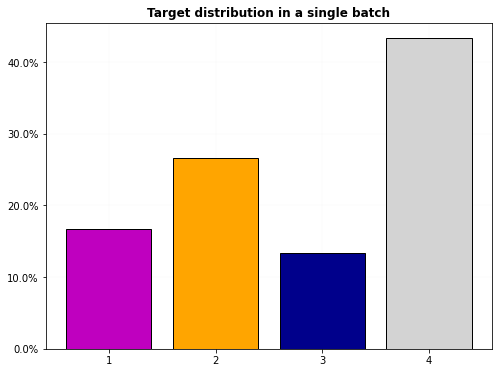

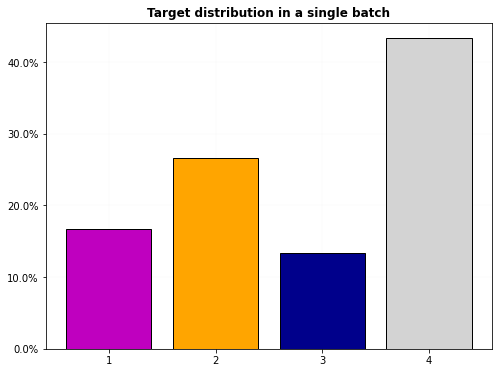

'1'

In [ ]:
# multiclass
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, on_disk=True, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, TSCategorize()], splits=splits, inplace=True)
dls.show_dist()
dls.train.show_dist()
xb,yb = first(dls.train)
test_eq((dls.cat, dls.c), (True, 4))
test_ne(dls.cws.cpu().numpy(), None)
dls.decoder((xb, ))
dls.decoder((xb[0], ))
dls.decoder((xb, yb))
dls.decoder((xb[0], yb[0]))
dls.decoder(yb)
dls.decoder(yb[0])

In [ ]:
new_dl = dls.new_dl(X)
first(new_dl)

(TSTensor(samples:60, vars:1, len:570, device=cpu),)

In [ ]:
new_dl = dls.new_dl(X, y=y)
first(new_dl)

(TSTensor(samples:60, vars:1, len:570, device=cpu),
 TensorCategory([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

In [ ]:
dls.train.dataset.split_idxs, dls.train.dataset.splits, dls.valid.split_idxs

((#30) [0,1,2,3,4,5,6,7,8,9...],
 (#30) [0,1,2,3,4,5,6,7,8,9...],
 (#30) [30,31,32,33,34,35,36,37,38,39...])

In [ ]:
# 2d input array and tfms == None return a NoTfmLists object
X, y, splits = get_UCR_data('OliveOil', on_disk=False, split_data=False)
X = X[:, 0]
tfms=[None, TSCategorize()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=8)
test_eq(1, dls.vars)
test_eq(X.shape[-1], dls.len)
test_eq(type(dls.tls[0]).__name__, 'NoTfmLists')
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=8, inplace=False)
test_eq(1, dls.vars)
test_eq(X.shape[-1], dls.len)
test_eq(type(dls.tls[0]).__name__, 'NoTfmLists')

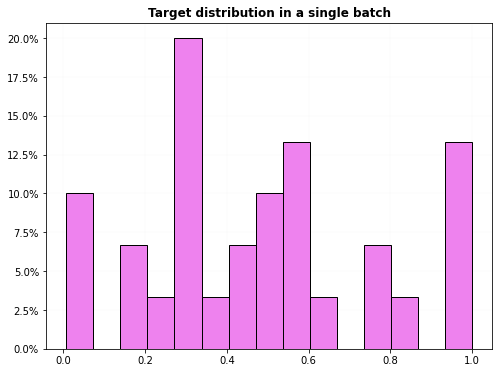

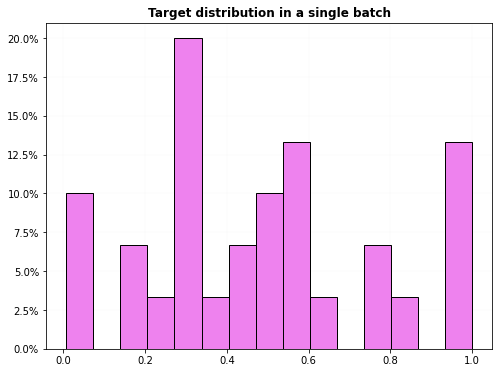

In [ ]:
# regression
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, on_disk=True, split_data=False)
dls = get_ts_dls(X, np.random.rand(60, ), tfms=[None, ToNumpyTensor], splits=splits)
dls.show_dist()
dls.train.show_dist()
xb,yb = first(dls.train)
dls.decoder((xb, ))
dls.decoder((xb[0], ))
dls.decoder((xb, yb))
dls.decoder((xb[0], yb[0]))
dls.decoder(yb)
dls.decoder(yb[0])
test_eq((dls.cat, dls.c), (False, 1))
test_eq(dls.cws, None)

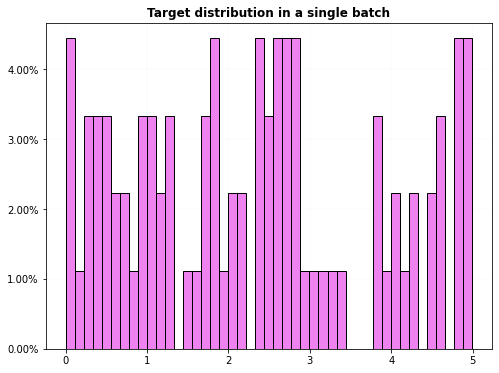

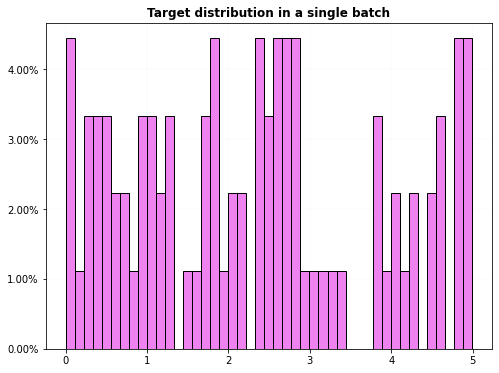

In [ ]:
# regression, multilabel
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, on_disk=True, split_data=False)
dls = get_ts_dls(X, np.random.rand(60, 3) * 5, tfms=[None, ToNumpyTensor], splits=splits)
dls.show_dist()
dls.train.show_dist()
xb,yb = first(dls.train)
dls.decoder((xb, ))
dls.decoder((xb[0], ))
dls.decoder((xb, yb))
dls.decoder((xb[0], yb[0]))
dls.decoder(yb)
dls.decoder(yb[0])
test_eq((dls.cat, dls.c, dls.d),(False, 1, 3)) 
test_eq(dls.cws, None)

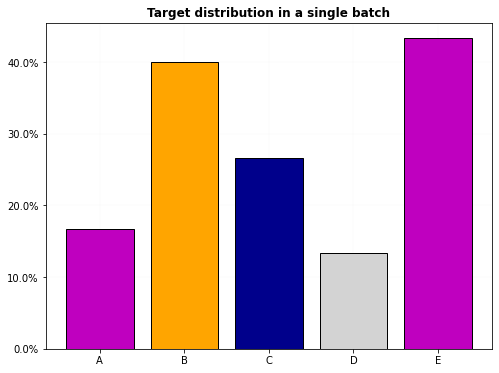

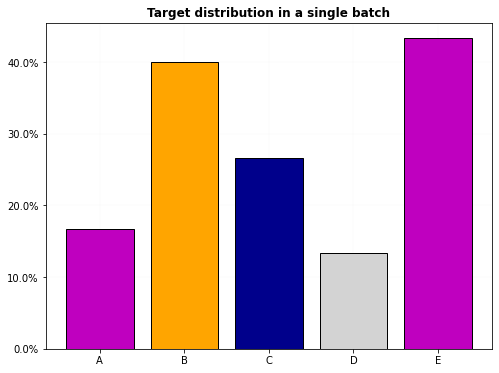

In [ ]:
# multiclass, multilabel
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, on_disk=True, split_data=False)
cm = {
    '1':'A',        
    '2':['B', 'C'],
    '3':['B', 'D'] , 
    '4':'E', 
    }
keys = cm.keys()
new_cm = {k:v for k,v in zip(keys, [listify(v) for v in cm.values()])}
y_multi = np.array([new_cm[yi] if yi in keys else listify(yi) for yi in y], dtype=object)
dls = get_ts_dls(X, y_multi, tfms=[None, TSMultiLabelClassification()], splits=splits)
dls.show_dist()
dls.train.show_dist()
xb,yb = first(dls.train)
dls.decoder((xb, ))
dls.decoder((xb[0], ))
dls.decoder((xb, yb))
dls.decoder((xb[0], yb[0]))
dls.decoder(yb)
dls.decoder(yb[0])
test_eq((dls.cat, dls.c), (True, 5))
test_ne(dls.cws.cpu().numpy(), None)

In [ ]:
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, on_disk=True, split_data=False)
cm = {
    '1':'A',        
    '2':['B', 'C'],
    '3':['B', 'D'] , 
    '4':'E', 
    }
keys = cm.keys()
new_cm = {k:v for k,v in zip(keys, [listify(v) for v in cm.values()])}
y_multi = np.array([new_cm[yi] if yi in keys else listify(yi) for yi in y], dtype=object)
dls = get_ts_dls(X, y_multi, tfms=[None, TSMultiLabelClassification()], splits=splits)
test_eq(dls.new(X[0]).one_batch().shape, (1, 570))
test_eq(dls.new(X[:15]).one_batch().shape, (15, 1, 570))
test_eq(dls.train.new(X[0]).one_batch().shape, (1, 570))
test_eq(dls.valid.new(X[:15]).one_batch().shape, (15, 1, 570))

In [ ]:
bs = 25
dsets = TSDatasets(X, y, tfms=[None, TSCategorize()], splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2], batch_tfms=add(1), num_workers=0)
xb,yb = dls.train.one_batch()
test_eq(xb.cpu().data, tensor(X_on_disk[splits[0]][dls.train.idxs]) + 1)

In [ ]:
dsets = TSDatasets(X, y, tfms=[None, TSCategorize()], splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])
xb,yb = dls.train.one_batch()
test_eq(xb.shape, (min(bs, len(splits[0])), X.shape[1], X.shape[-1]))
it = iter(dls.valid)
for xb,yb in it: 
    test_close(xb.cpu(), TSTensor(X[splits[1]][dls.valid.idxs]))

/Users/nacho/opt/anaconda3/envs/py37torch110/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


In [ ]:
bs = 64
dsets = TSDatasets(X, y, tfms=[add(1), TSCategorize()], splits=RandomSplitter(valid_pct=.3)(y_array))
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])
xb,yb = dls.train.one_batch()
test_eq(xb.shape, (min(bs, len(dsets.train)), X_on_disk.shape[1], X_on_disk.shape[-1]))
xb,yb = dls.valid.one_batch()
test_eq(xb.shape, (min(bs*2, len(dsets.valid)), X_on_disk.shape[1], X_on_disk.shape[-1]))

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=[None, TSCategorize()], splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[32, 64])
for i in range(10):
    dl = dls.train if random.random() < .5 else dls.valid
    xb,yb = dl.one_batch()
    torch.equal(xb.cpu(), TSTensor(X_on_disk[dl.input_idxs]))
    
dsets = TSDatasets(X_on_disk, y_array, tfms=[None, TSCategorize()])
dls   = TSDataLoaders.from_dsets(dsets, bs=32)
for i in range(10):
    xb,yb = dls.one_batch()
    torch.equal(xb.cpu(), TSTensor(X_on_disk[dl.input_idxs]))
    
dsets = TSDatasets(X_on_disk, tfms=None)
dls   = TSDataLoaders.from_dsets(dsets, bs=32)
for i in range(10):
    xb = dls.one_batch()
    torch.equal(xb[0].cpu(), TSTensor(X_on_disk[dl.input_idxs]))

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=[None, TSCategorize()])
dls   = TSDataLoaders.from_dsets(dsets, bs=32)
test_eq_type(dls.split_idxs, L(np.arange(len(X_on_disk)).tolist()))

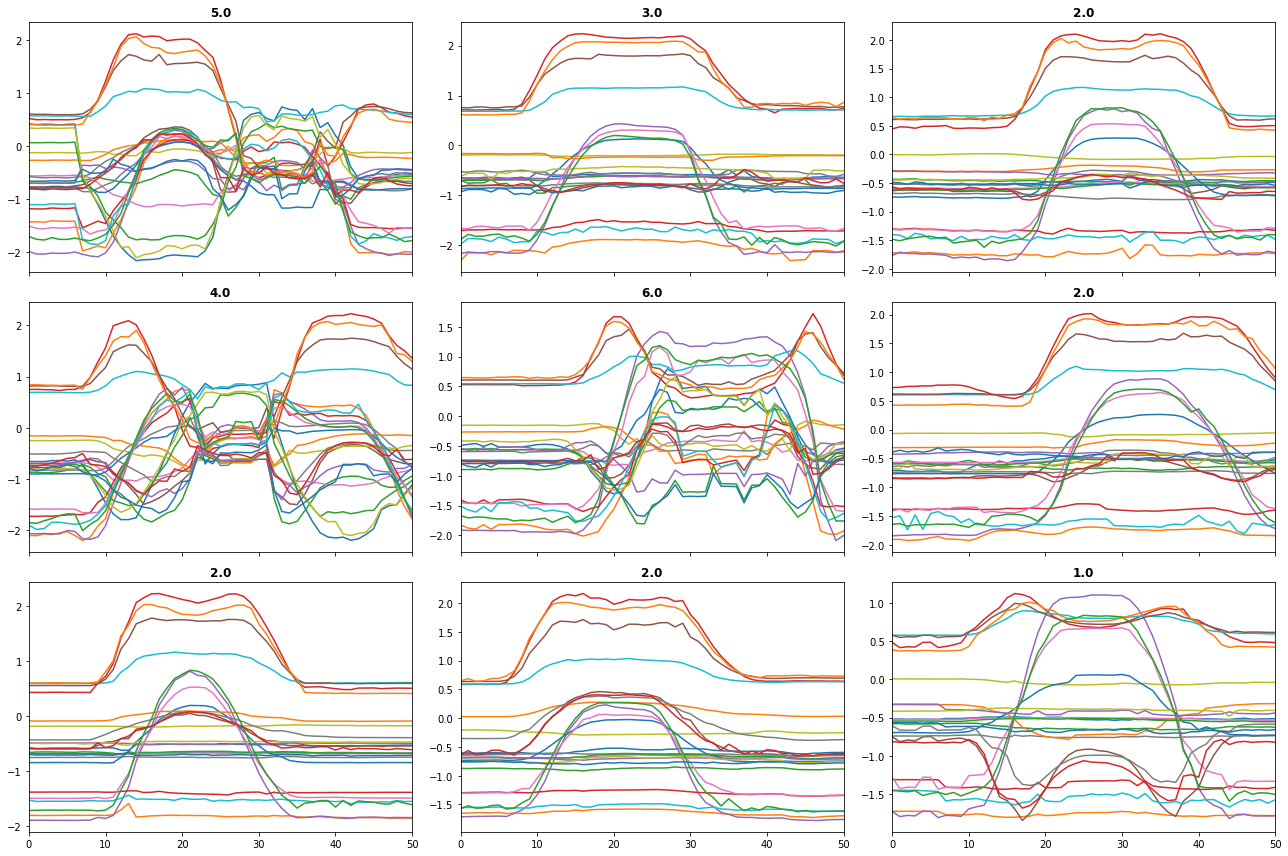

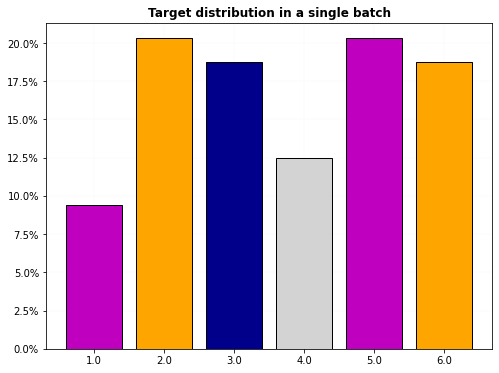

In [ ]:
X, y, splits = get_UCR_data('NATOPS', return_split=False)
tfms  = [None, [TSCategorize()]]
dls = get_ts_dls(X, y, tfms=tfms, splits=splits, bs=[64, 128])
dls.show_batch()
dls.show_dist()

In [ ]:
# test passing a list with categories instead of a numpy array 
dsid = 'NATOPS'
bs = 64
X2, y2, splits2 = get_UCR_data(dsid, return_split=False)
vocab = sorted(set(y))
tfms = [None, [TSCategorize(vocab=vocab)]]
dsets = TSDatasets(X2, y2, tfms=tfms, splits=splits2)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])
dls.train.one_batch()

(TSTensor(samples:64, vars:24, len:51, device=cpu),
 TensorCategory([3, 3, 4, 5, 5, 0, 5, 1, 1, 2, 2, 4, 3, 2, 0, 3, 5, 3, 5, 5, 0, 5, 0, 2,
         1, 1, 1, 4, 2, 5, 5, 0, 4, 0, 4, 5, 3, 1, 1, 1, 3, 0, 2, 4, 4, 3, 2, 5,
         5, 4, 5, 0, 0, 0, 5, 2, 1, 5, 4, 0, 2, 4, 4, 3]))

In [ ]:
# MultiCategory
bs = 64
n_epochs = 100
tfms = [None, [MultiCategorize()]]
dsets = TSDatasets(X2, y2, tfms=tfms, splits=splits2)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)
dls.train.one_batch()

(TSTensor(samples:64, vars:24, len:51, device=cpu),
 TensorMultiCategory([[5, 0, 1],
         [2, 0, 1],
         [7, 0, 1],
         [3, 0, 1],
         [7, 0, 1],
         [4, 0, 1],
         [3, 0, 1],
         [5, 0, 1],
         [5, 0, 1],
         [6, 0, 1],
         [4, 0, 1],
         [6, 0, 1],
         [6, 0, 1],
         [4, 0, 1],
         [2, 0, 1],
         [5, 0, 1],
         [7, 0, 1],
         [7, 0, 1],
         [3, 0, 1],
         [2, 0, 1],
         [2, 0, 1],
         [3, 0, 1],
         [2, 0, 1],
         [3, 0, 1],
         [2, 0, 1],
         [7, 0, 1],
         [5, 0, 1],
         [5, 0, 1],
         [6, 0, 1],
         [5, 0, 1],
         [5, 0, 1],
         [2, 0, 1],
         [7, 0, 1],
         [6, 0, 1],
         [7, 0, 1],
         [3, 0, 1],
         [3, 0, 1],
         [3, 0, 1],
         [4, 0, 1],
         [5, 0, 1],
         [4, 0, 1],
         [7, 0, 1],
         [4, 0, 1],
         [5, 0, 1],
         [2, 0, 1],
         [2, 0, 1],
         [7, 0,

The combination of splits, sel_vars and sel_steps is very powerful, as it allows you to perform advanced indexing of the array-like X.

In [ ]:
from tsai.data.validation import TSSplitter
X = np.arange(16*5*50).reshape(16,5,50)
y = alphabet[np.random.randint(0,3, 16)]
splits = TSSplitter(show_plot=False)(y)
tfms = [None, TSCategorize()]
batch_tfms = None
dls = get_ts_dls(X, y, splits=splits, sel_vars=[0, 1, 3], sel_steps=slice(-10, None), tfms=tfms, batch_tfms=batch_tfms)
xb,yb=dls.train.one_batch()
test_close(X[dls.input_idxs][:, [0, 1, 3]][...,slice(-10, None)], xb.cpu().numpy())
new_dl = dls.train.new_dl(X[:5], y[:5])
print(new_dl.one_batch())
new_empty_dl = dls.new_empty() # when exported
dl = new_empty_dl.new_dl(X[:10], y[:10], bs=64) # after export
dl.one_batch()

(TSTensor(samples:5, vars:3, len:10, device=cpu), TensorCategory([0, 1, 2, 2, 1]))


(TSTensor(samples:10, vars:3, len:10, device=cpu),
 TensorCategory([0, 1, 2, 2, 1, 0, 2, 2, 2, 0]))

In [ ]:
#hide
from tsai.imports import create_scripts
from tsai.export import get_nb_name
nb_name = get_nb_name()
create_scripts(nb_name);

<IPython.core.display.Javascript object>

013_data.core.ipynb saved at 2022-03-20 10:10:13.
Converted 013_data.core.ipynb.


Correct conversion! 😃
Total time elapsed 0.106 s
Sunday 20/03/22 10:10:17 CET
